In [2]:
import numpy as np

In [5]:
def shift(register, feedback, output):
    """GPS Shift Register
    
    :param list feedback: which positions to use as feedback (1 indexed)
    :param list output: which positions are output (1 indexed)
    :returns output of shift register:
    
    """
    
    # calculate output
    out = [register[i-1] for i in output]
    if len(out) > 1:
        out = sum(out) % 2
    else:
        out = out[0]
        
    # modulo 2 add feedback
    fb = sum([register[i-1] for i in feedback]) % 2
    
    # shift to the right
    for i in reversed(range(len(register[1:]))):
        register[i+1] = register[i]
        
    # put feedback in position 1
    register[0] = fb
    
    return out

In [6]:
SV = {
   1: [2,6],
   2: [3,7],
   3: [4,8],
   4: [5,9],
   5: [1,9],
   6: [2,10],
   7: [1,8],
   8: [2,9],
   9: [3,10],
  10: [2,3],
  11: [3,4],
  12: [5,6],
  13: [6,7],
  14: [7,8],
  15: [8,9],
  16: [9,10],
  17: [1,4],
  18: [2,5],
  19: [3,6],
  20: [4,7],
  21: [5,8],
  22: [6,9],
  23: [1,3],
  24: [4,6],
  25: [5,7],
  26: [6,8],
  27: [7,9],
  28: [8,10],
  29: [1,6],
  30: [2,7],
  31: [3,8],
  32: [4,9],
}

In [7]:
def PRN(sv):
    """Build the CA code (PRN) for a given satellite ID
    
    :param int sv: satellite code (1-32)
    :returns list: ca code for chosen satellite
    
    """
    
    # init registers
    G1 = [1 for i in range(10)]
    G2 = [1 for i in range(10)]

    ca = [] # stuff output in here
    
    # create sequence
    for i in range(1023):
        g1 = shift(G1, [3,10], [10])
        g2 = shift(G2, [2,3,6,8,9,10], SV[sv]) # <- sat chosen here from table
        
        # modulo 2 add and append to the code
        ca.append((g1 + g2) % 2)

    # return C/A code!
    return ca


In [5]:
res = PRN(2)
print(res[:10])
#I stole literally all of this from https://natronics.github.io/blag/2014/gps-prn/

[1, 1, 1, 0, 0, 1, 0, 0, 0, 0]


In [46]:
fs = 1.023*16*1e6
data = np.fromfile('adc_sample_data.bin', dtype=np.int8)
print(len(data))
data = np.sign(data[:len(data)//10])
t = np.arange(0,len(data))*1/(fs)

16368000


In [15]:
f_carrier = 4.128460*1e6
I = np.sign(data*np.cos(2*np.pi*f_carrier*t))
Q = np.sign(data*np.sin(2*np.pi*f_carrier*t))

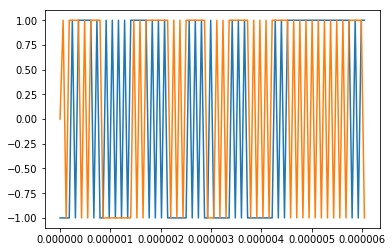

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t[:100], I[:100])
plt.plot(t[:100], Q[:100])
plt.show()

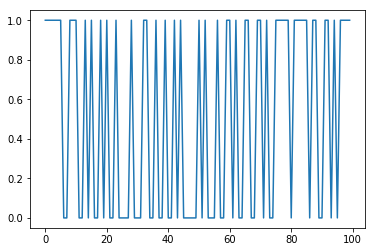

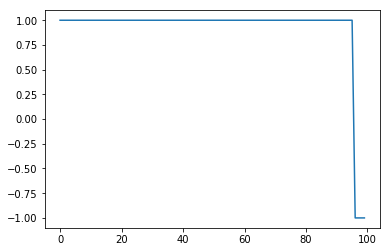

In [22]:
code = PRN(22)
plt.figure()
plt.plot(code[:100])
code_at_freq = np.repeat(code, 16)*2 - 1
plt.figure()
plt.plot(code_at_freq[:100])

In [23]:
correlator_out = np.correlate(I, code_at_freq)
print(len(correlator_out))

1620433


In [24]:
correlator_out_trunc = correlator_out[::4]
print(max(correlator_out_trunc))

2812.0


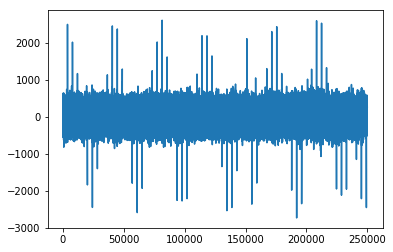

In [25]:
plt.plot(correlator_out[:1000000:4])

In [26]:
print(np.argmax(correlator_out[:40000]))

15040


In [112]:
from blocks import *
raw_data = np.fromfile('adc_sample_data.bin', dtype=np.int8)[15041:]
print(len(raw_data))
# Data sample rate
fs = 1.023*16*1e6

# The data contains the following SV's with at the following frequencies:
# The frequencies are in MHz
sv_list = [22, 3, 19, 14, 18, 11, 32, 6]
sv_freqs = [4.128460, 4.127190, 4.129280,
            4.133130, 4.127310, 4.133280,
            4.134060,4.127220]

sv = sv_list[0]
sv_freq = sv_freqs[0]

# We'll start off with the NCO Width set to 10
nco_width = 14
ideal_carrier_nco_code = sv_freq*1e6 * (2**nco_width) / fs
carrier_nco_code = round(ideal_carrier_nco_code)

num_cycles = len(raw_data)//10
print(num_cycles)

adc = ADC(np.sign(raw_data))
nco_carrier = NCO(nco_width, False)

multI = MUL()
multQ = MUL()

multIe = MUL()
multIp = MUL()
multIl = MUL()
multQe = MUL()
multQp = MUL()
multQl = MUL()

ca = CA()

intdumpI = IntDump()
intdumpQ = IntDump()

# ki = 1, kp = 1, second discriminator
dll = DLL(1, 1, 1)
# Disabling the Costas loop for now and forcing the right frequency
costas = Costas(1,[1,1,1],1,1,1)    

nco_code = NCO(nco_width, True)
packet = Packet()

# FIXME: Initial DLL and Costas loop values
dll_out = 1023e3*(2**nco_width)/fs
costas_out = carrier_nco_code
I_samples = []
Q_samples = []
I_integ_samples = []
Q_integ_samples = []
I_dump_samples = []
Q_dump_samples = []
processed = False

for x in range(0, num_cycles):
    adc_data = np.sign(adc.update())
    cos_out, sin_out  = nco_carrier.update(costas_out)        
    I = multI.update(adc_data, cos_out)
    Q = multQ.update(adc_data, sin_out)
    I_samples.append(I)
    Q_samples.append(Q)
    
    f_out, f2_out = nco_code.update(dll_out)
    e, p, l, dump = ca.update(f_out, f2_out, sv)


    I_e = multIe.update(I, e)        
    I_p = multIp.update(I, p)
    I_l = multIl.update(I, l)
    Q_e = multQe.update(Q, e)
    Q_p = multQp.update(Q, p)
    Q_l = multQl.update(Q, l)
    I_sample = [I_e, I_p, I_l]
    Q_sample = [Q_e, Q_p, Q_l]
    
    if dump and not processed:
        print(x)
        dll_out, dis_out = dll.update(I_int, Q_int, 1023e3*(2**nco_width)/fs, 0)
        I_dump_samples.append(I_int.copy())
        Q_dump_samples.append(Q_int.copy())
        processed = True
    elif not dump: 
        processed = False
        
    I_integ_samples.append(I_sample)
    Q_integ_samples.append(Q_sample)
    I_int = intdumpI.update(np.array(I_sample), dump)
    Q_int = intdumpQ.update(np.array(Q_sample), dump)

    
  
    


16352959
1635295
16367
DIS OUT:  0.4103064908750466
32740
DIS OUT:  0.3877792060807736
49120
DIS OUT:  0.045745778562685656
65500
DIS OUT:  0.15498526526194933
81883
DIS OUT:  0.34847099738283
98272
DIS OUT:  0.040373084683265476
114661
DIS OUT:  -0.24518760280272736
131046
DIS OUT:  0.11743101747988646
147434
DIS OUT:  0.29793894445851843
163825
DIS OUT:  0.18089589931419642
180220
DIS OUT:  -0.03330338814291435
196615
DIS OUT:  0.323013296386991
213014
DIS OUT:  -0.35681995477108286
229408
DIS OUT:  0.14837129522559273
245804
DIS OUT:  0.09084952243048611
262202
DIS OUT:  0.03057468024021246
278600
DIS OUT:  0.17902104109250488
295001
DIS OUT:  0.20754237677883636
311405
DIS OUT:  -0.2890941964406539
327805
DIS OUT:  -0.28447340575785385
344200
DIS OUT:  -0.20471674739016424
360592
DIS OUT:  0.016047046294933212
376984
DIS OUT:  0.02638105026584175
393376
DIS OUT:  0.20528341142001152
409772
DIS OUT:  -0.12092009965590418
426166
DIS OUT:  -0.07170943665165426
442558
DIS OUT:  -0.0391

In [113]:
I_out = np.array(I_samples)
Q_out = np.array(Q_samples)
I_dump_samples = np.array(I_dump_samples)
Q_dump_samples = np.array(Q_dump_samples)
I_integ_samples = np.array(I_integ_samples)
Q_integ_samples = np.array(Q_integ_samples)

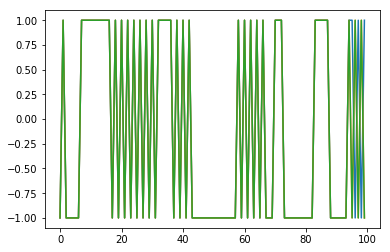

In [114]:
plt.plot(I_integ_samples[:100])

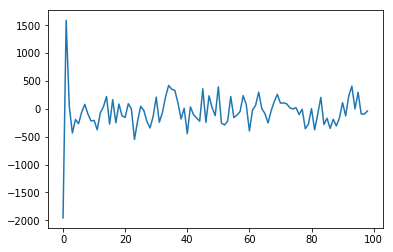

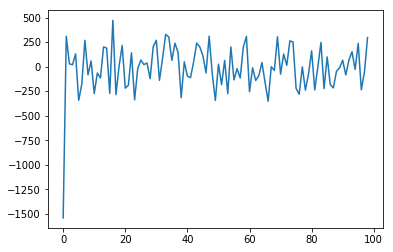

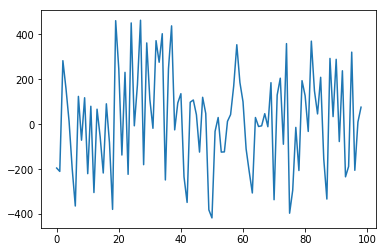

In [115]:
plt.plot(I_dump_samples[:32000,0])
plt.figure()
plt.plot(I_dump_samples[:32000,1])
plt.figure()
plt.plot(I_dump_samples[:32000,2])

In [69]:
code = PRN(22)
code_at_freq = np.repeat(code, 16)*2 - 1
correlated_out = np.correlate(code_at_freq, I_out, mode='full')

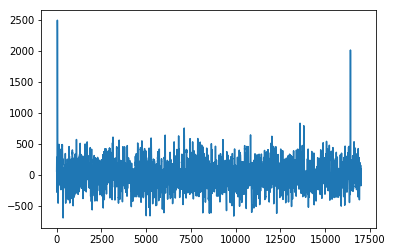

In [74]:
plt.plot(correlator_out[15000:32000])

In [75]:
print(np.argmax(correlator_out[15100:32000]))

16308


In [76]:
16308 - 16367 + 15100

15041